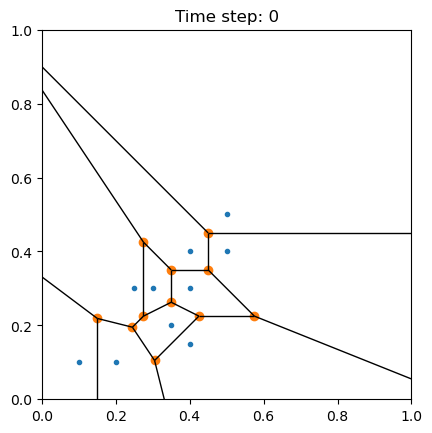

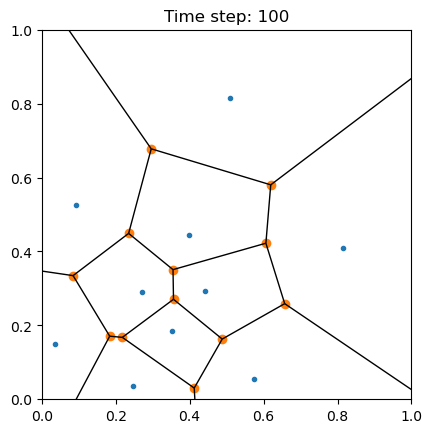

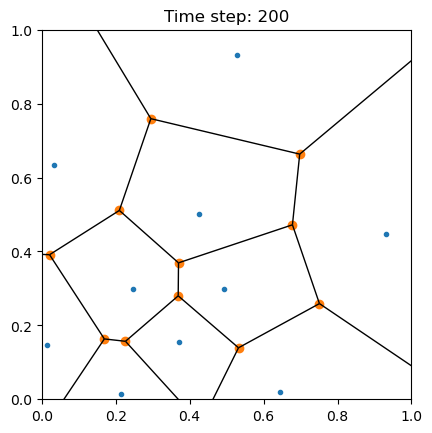

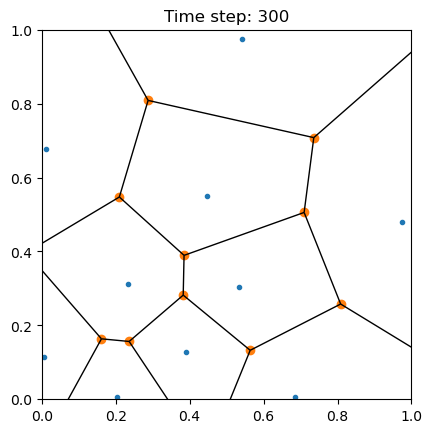

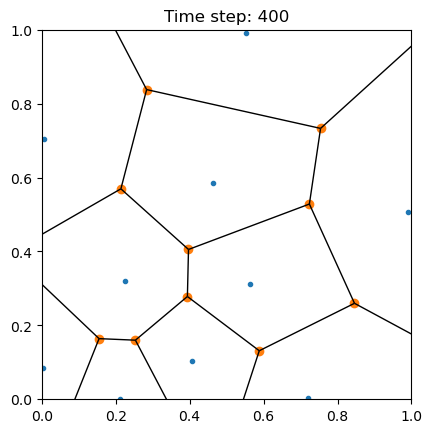

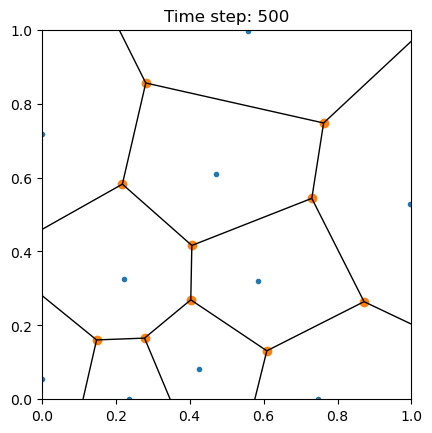

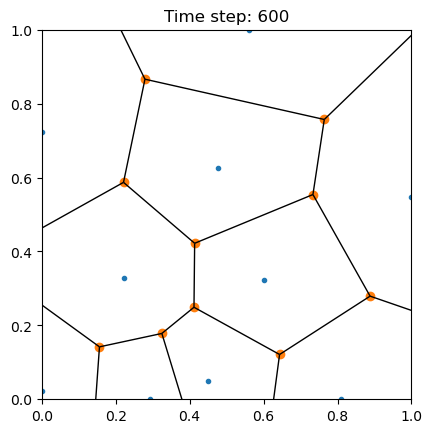

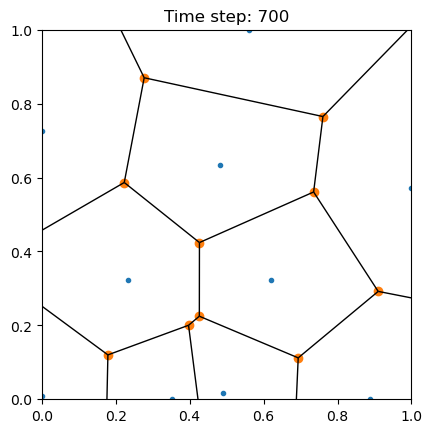

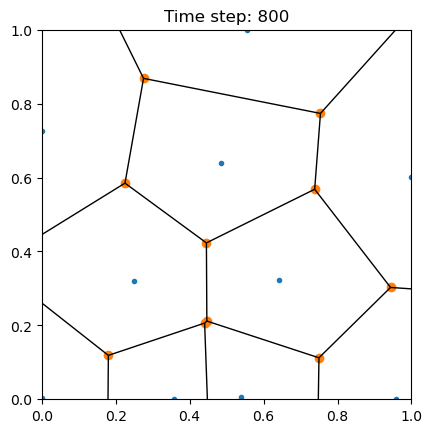

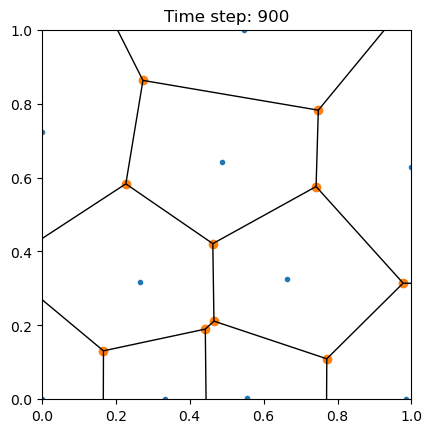

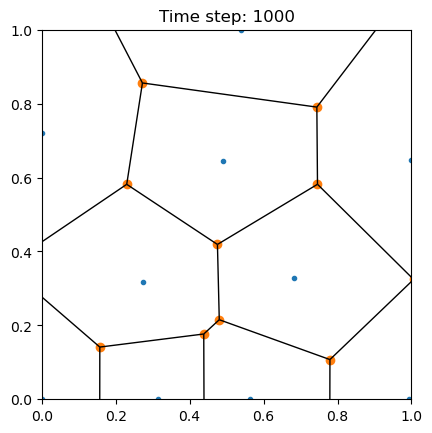

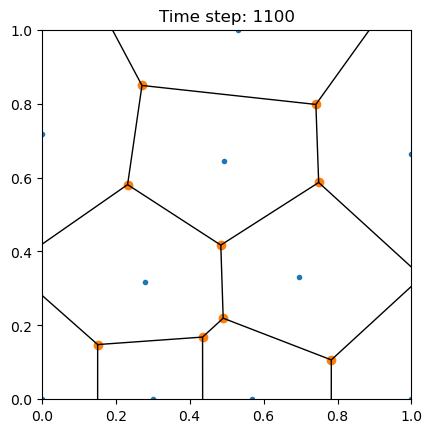

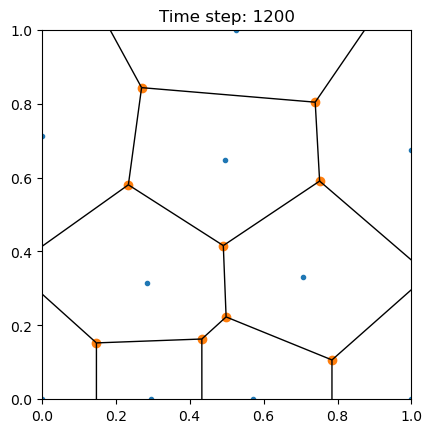

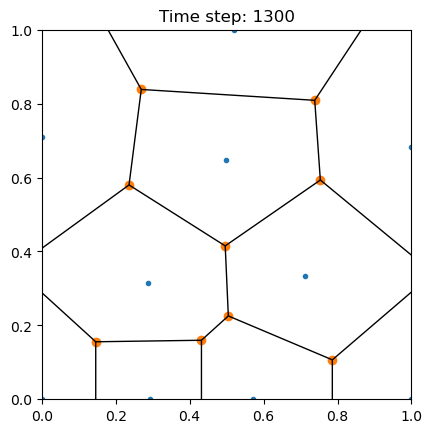

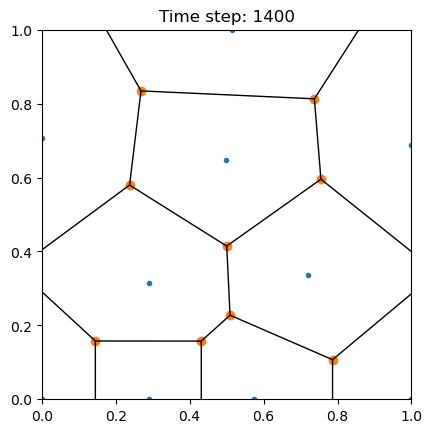

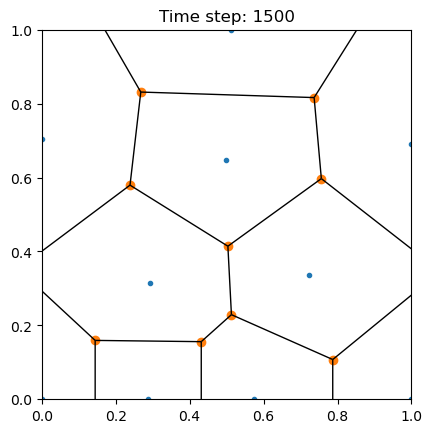

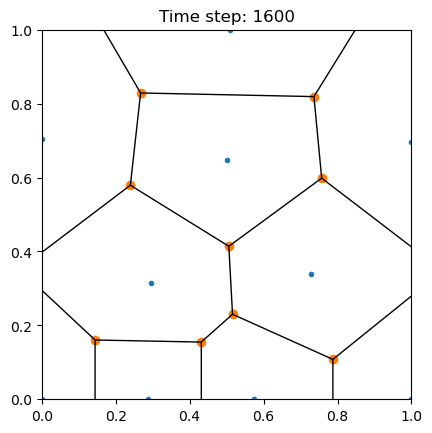

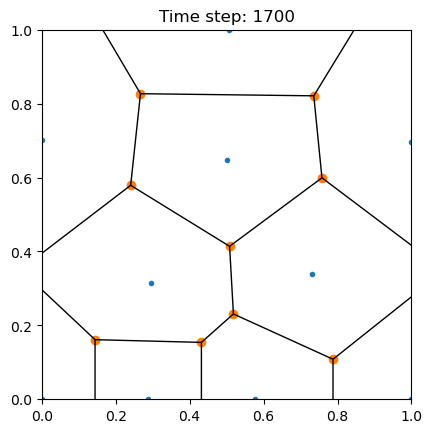

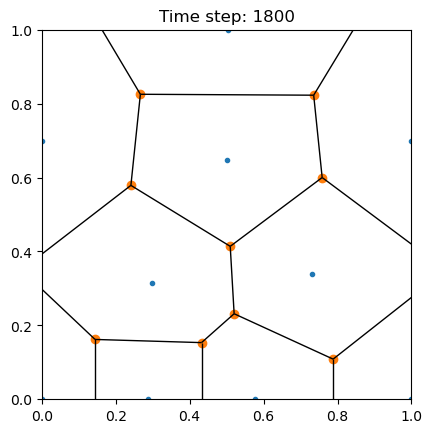

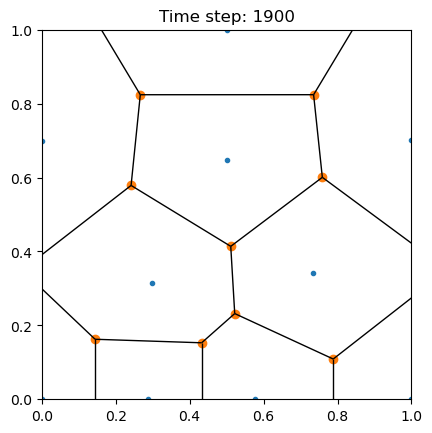

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.integrate import odeint


def simple_voronoi_centroid(x, workspace_bounds):
    """
    简化的 Voronoi 质心计算，不依赖 shapely
    """
    # 添加边界点以确保 Voronoi 图覆盖整个区域
    x_min, x_max, y_min, y_max = workspace_bounds
    padding = 1.0
    
    boundary_points = np.array([
        [x_min - padding, y_min - padding],
        [x_max + padding, y_min - padding],
        [x_min - padding, y_max + padding],
        [x_max + padding, y_max + padding]
    ])
    
    points = np.vstack([x, boundary_points])
    vor = Voronoi(points)
    
    # 简化的质心计算 - 使用 Voronoi 顶点平均
    vcentroid = np.zeros_like(x)
    
    for i in range(len(x)):
        region_index = vor.point_region[i]
        region = vor.regions[region_index]
        
        if -1 not in region and len(region) > 0:
            # 使用 Voronoi 区域的顶点计算质心
            vertices = np.array([vor.vertices[v] for v in region])
            # 简单的质心计算（多边形质心的近似）
            cell_centroid = np.mean(vertices, axis=0)
            
            # 将质心限制在工作空间内
            cell_centroid[0] = np.clip(cell_centroid[0], x_min, x_max)
            cell_centroid[1] = np.clip(cell_centroid[1], y_min, y_max)
            
            vcentroid[i] = cell_centroid
        else:
            vcentroid[i] = x[i]  # 如果区域无效，使用当前位置
    
    return vcentroid, vor

# main
workspace_bounds = [0, 1, 0, 1]  # [x_min, x_max, y_min, y_max]
x0 = np.array([[0.1, 0.1], [0.2, 0.1], [0.25, 0.3], [0.35, 0.2], 
               [0.3, 0.3], [0.5, 0.5], [0.4, 0.15], [0.4, 0.3], 
               [0.4, 0.4], [0.5, 0.4]])

t = np.arange(0, 20, 0.01)  # 缩短仿真时间用于测试

# control
def MAS(x, t):
    x_arr = np.array(x).reshape(-1, 2)
    dxdt = []
    
    for i in range(len(x_arr)):
        cent, vor = simple_voronoi_centroid(x_arr, workspace_bounds)
        u_i = -1 * (x_arr[i] - cent[i])
        dxdt.append(u_i.tolist())
    
    return sum(dxdt, [])

# 运行仿真
x = odeint(MAS, np.array(sum(x0.tolist(), [])), t)

# 可视化
for i in range(len(x)):
    if i % 100 == 0:
        cent, vor = simple_voronoi_centroid(np.array(x[i]).reshape(-1, 2), workspace_bounds)
        voronoi_plot_2d(vor)
        plt.gca().set_aspect('equal')
        plt.gca().set_xlim([0, 1])
        plt.gca().set_ylim([0, 1])
        plt.title(f'Time step: {i}')
        plt.show()